In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional,GlobalMaxPooling1D

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# load dataset

In [2]:
data = pd.read_csv('Bot Dataset.csv')
data.head()

,tag,Question,Answer
0,user 1,Apa itu penyakit mental?,Penyakit mental adalah kondisi kesehatan yang ...
1,user 2,Siapa yang mempengaruhi penyakit mental?,Diperkirakan bahwa penyakit mental mempengaruh...
2,user 3,Apa yang menyebabkan penyakit mental?,Diperkirakan bahwa penyakit mental mempengaruh...
3,user 4,Apa saja tanda -tanda peringatan penyakit mental?,Gejala gangguan kesehatan mental bervariasi te...
4,user 5,Bisakah orang dengan penyakit mental pulih?,"Ketika penyembuhan dari penyakit mental, ident..."


# inisialisasi stop words

In [3]:
stopwords = []
with open('stopwords.txt', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

In [4]:
# fungsi untuk menghilangkan stopwords
def remove_stopwords(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    temp = re.sub(r'[.,’"\'-?:!;]', '', text)
    text = re.sub(r'^Apa|^Saya|^Aku|^maukah|^Siapa|^Bagaimana|^Dimana|^Kapan|^Kenapa', '', text)
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)

In [5]:
# menghilangkan stopwords dari dataset
data['Question'] = data['Question'].apply(remove_stopwords)
print(data['Question'])

0                             penyakit mental
1                mempengaruhi penyakit mental
2                 menyebabkan penyakit mental
3      tanda tanda peringatan penyakit mental
4                 orang penyakit mental pulih
                        ...                  
153                                     stres
154                            berhasil hidup
155                                         p
156                           assalamualaikum
157                              teman curhat
Name: Question, Length: 158, dtype: object


# inisialisasi tokenizer

In [6]:
# inisialisasi tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['Question'])

In [7]:
# fungsi untuk mengganti kata typo dengan kata yang paling mirip pada dataset
def correct_typo(word):
    max_score = -1
    correct_word = word
    for vocab_word in tokenizer.word_index:
        score = fuzz.ratio(word, vocab_word)
        if score > max_score:
            max_score = score
            correct_word = vocab_word
    return correct_word

# fungsi untuk mengoreksi typo pada kalimat
def correct_sentence(sentence):
    corrected_sentence = []
    words = sentence.split()
    for word in words:
        corrected_word = correct_typo(word)
        corrected_sentence.append(corrected_word)
    return ' '.join(corrected_sentence)

# fungsi untuk membersihkan dan memproses input pengguna
def preprocess_input(text):
    text = remove_stopwords(text)
    text = correct_sentence(text)
    return text


# encoding label Respon

In [8]:
encoder = LabelEncoder()
encoder.fit(data['Answer'])
encoded_labels = encoder.transform(data['Answer'])

# split data menjadi train dan validation set

In [9]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]

train_seq = tokenizer.texts_to_sequences(train_data['Question'])
val_seq = tokenizer.texts_to_sequences(val_data['Question'])

train_label_seq = encoded_labels[:train_size]
val_label_seq = encoded_labels[train_size:]

# padding sequence

In [10]:
train_seq = pad_sequences(train_seq, maxlen=100, truncating='post')
val_seq = pad_sequences(val_seq, maxlen=100, truncating='post')

# callback

In [11]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.998:
            print("\n\nAccuracy Has Been Achieved Around 99.8%, Training Stop!\n")
            self.model.stop_training = True

# MODEL

In [12]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 16, input_length=100),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(159, activation='softmax')
])
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
# training model
history = model.fit(train_seq, train_label_seq, epochs=200,callbacks=[Callback()])

Epoch 1/200
4/4 [==============================] - 1s 16ms/step - loss: 5.0718 - accuracy: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 5.0640 - accuracy: 0.0079
Epoch 3/200
4/4 [==============================] - 0s 12ms/step - loss: 5.0580 - accuracy: 0.0397
Epoch 4/200
4/4 [==============================] - 0s 14ms/step - loss: 5.0530 - accuracy: 0.0317
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 5.0454 - accuracy: 0.0714
Epoch 6/200
4/4 [==============================] - 0s 13ms/step - loss: 5.0357 - accuracy: 0.0476
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 5.0248 - accuracy: 0.0476
Epoch 8/200
4/4 [==============================] - 0s 12ms/step - loss: 5.0104 - accuracy: 0.1111
Epoch 9/200
4/4 [==============================] - 0s 9ms/step - loss: 4.9928 - accuracy: 0.1032
Epoch 10/200
4/4 [==============================] - 0s 11ms/step - loss: 4.9728 - accuracy: 0.1190
Epoch 11/200
4/4 

4/4 [==============================] - 0s 13ms/step - loss: 0.8766 - accuracy: 0.8492
Epoch 85/200
4/4 [==============================] - 0s 14ms/step - loss: 0.8096 - accuracy: 0.8413
Epoch 86/200
4/4 [==============================] - 0s 10ms/step - loss: 0.7597 - accuracy: 0.8571
Epoch 87/200
4/4 [==============================] - 0s 9ms/step - loss: 0.7865 - accuracy: 0.8651
Epoch 88/200
4/4 [==============================] - 0s 11ms/step - loss: 0.6984 - accuracy: 0.8571
Epoch 89/200
4/4 [==============================] - 0s 9ms/step - loss: 0.7541 - accuracy: 0.8571
Epoch 90/200
4/4 [==============================] - 0s 9ms/step - loss: 0.7451 - accuracy: 0.8730
Epoch 91/200
4/4 [==============================] - 0s 6ms/step - loss: 0.7526 - accuracy: 0.8571
Epoch 92/200
4/4 [==============================] - 0s 8ms/step - loss: 0.6683 - accuracy: 0.8889
Epoch 93/200
4/4 [==============================] - 0s 9ms/step - loss: 0.6639 - accuracy: 0.8492
Epoch 94/200
4/4 [===========

4/4 [==============================] - 0s 10ms/step - loss: 0.3679 - accuracy: 0.9127
Epoch 167/200
4/4 [==============================] - 0s 10ms/step - loss: 0.3302 - accuracy: 0.9127
Epoch 168/200
4/4 [==============================] - 0s 11ms/step - loss: 0.2942 - accuracy: 0.9048
Epoch 169/200
4/4 [==============================] - 0s 12ms/step - loss: 0.2780 - accuracy: 0.9444
Epoch 170/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3129 - accuracy: 0.8810
Epoch 171/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3773 - accuracy: 0.9048
Epoch 172/200
4/4 [==============================] - 0s 11ms/step - loss: 0.3301 - accuracy: 0.9048
Epoch 173/200
4/4 [==============================] - 0s 9ms/step - loss: 0.2568 - accuracy: 0.9127
Epoch 174/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3757 - accuracy: 0.9048
Epoch 175/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3671 - accuracy: 0.8889
Epoch 176/200
4/4 [

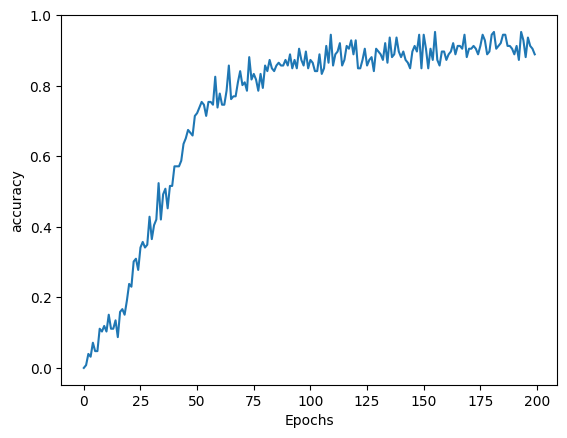

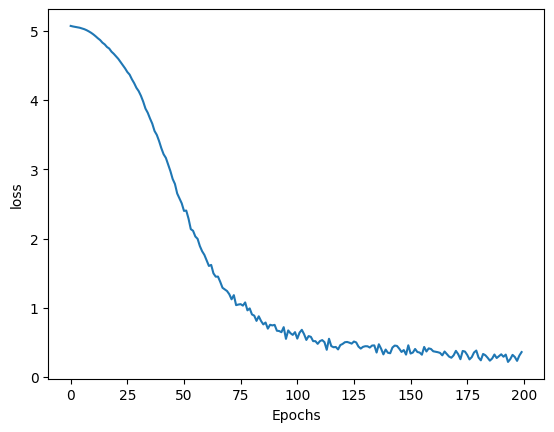

In [14]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# TESTING

In [17]:
try:
    input_text = input('Masukkan pertanyaan: ')
    preprocessed_text = preprocess_input(input_text)
    input_seq = tokenizer.texts_to_sequences([preprocessed_text])
    input_seq = pad_sequences(input_seq, maxlen=100)
    predicted_label_seq = model.predict(input_seq)
    predicted_label = encoder.inverse_transform(predicted_label_seq.argmax(axis=-1))[0]
    print('Jawaban: ', predicted_label)
except:
    print("Bot : maaf saya tidak memahami maksud anda")

Masukkan pertanyaan: apa negara dengan depresi tertinggi
1/1 [==============================] - 0s 31ms/step
Jawaban:  Lembar info kami tentang gangguan mood, gangguan bipolar, dan depresi menawarkan informasi tentang masalah suasana hati, pilihan perawatan, dan sumber daya di BC. Kami juga menawarkan apa itu depresi? Ini adalah buklet dengan audio dalam bahasa sederhana untuk pembaca literasi yang lebih rendah. Anda dapat mengambil tes swadaya skrining untuk depresi (dan masalah kesehatan mental lainnya). Alat Depresi Dewasa juga menyaring tanda -tanda gangguan bipolar.
Jika Anda ingin melampaui dasar -dasarnya, seri Depresi Pengelolaan kami dapat membantu Anda menangani diagnosis depresi, bekerja dengan dokter, dan mencegah kekambuhan depresi. Anda juga akan menemukan banyak pengalaman dan perspektif seputar depresi - membaca kisah -kisah pribadi dapat membantu Anda merasa kurang sendirian.
